# INFO
Notebook for replicating the experiment of learning Advection-Diffusion system here: https://www.youtube.com/watch?v=1bS0q0RkoH0

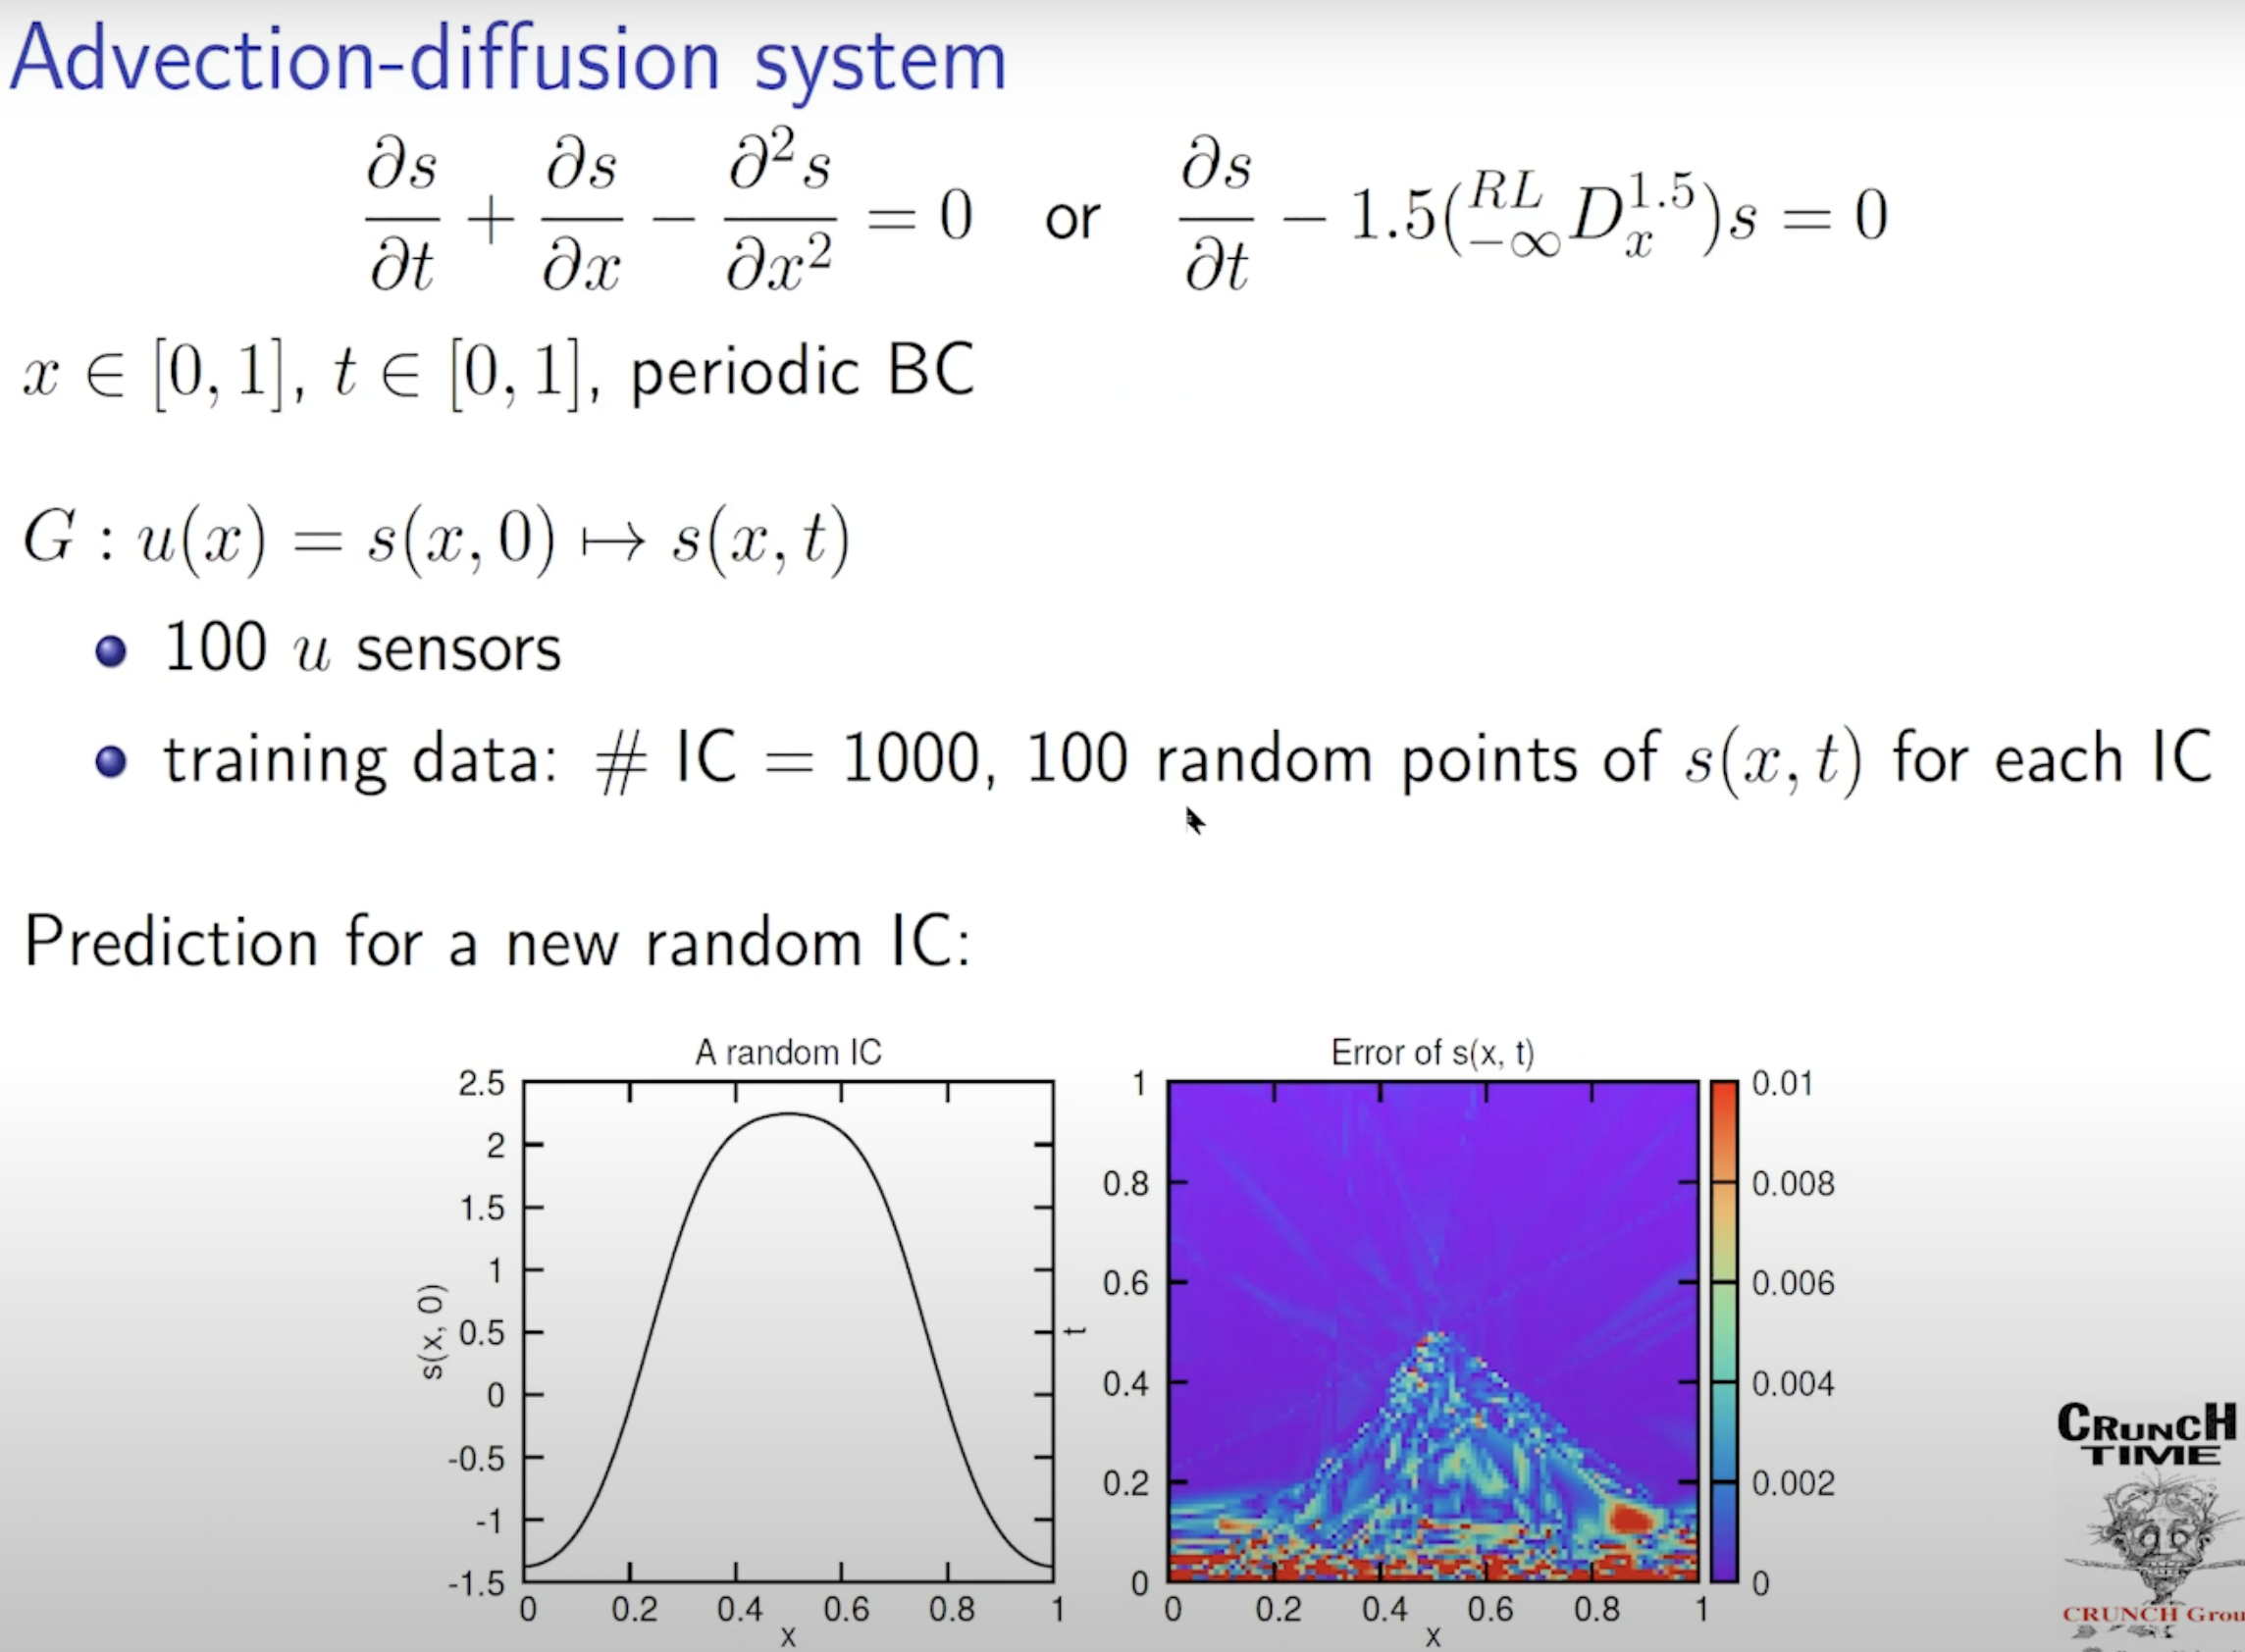

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from glob import glob
import sys
import os
import seaborn as sns

sys.path.insert(1, '../src')
from model import *
from wave_loader import *

sns.set()
root = '..'

In [2]:
def save_model(model, foldername):
    if not os.path.exists(root + '/models/' + foldername):
        os.makedirs(root + '/models/' + foldername)

    filename = str(model) + '.pt'
    torch.save(model.state_dict(), root + '/models/' + foldername + '/' + filename)


def save_results(losses, foldername, filename):
    if not os.path.exists(root + '/results/' + foldername):
        os.makedirs(root + '/results/' + foldername)

    np.save(root + '/results/' + foldername + '/' + filename, losses)

In [16]:
# Load training set with 
# 1000 initial conditions
# 100 sensors for each IC
# 100 random spacetime points for each IC
# 100 targets - 1 for each spacetime point
paths = glob(root + '/data/training2/*.npy')
ds_train, ds_valid = get_wave_datasets(paths)

In [17]:
# Train large model
#model = DeepONet(100, 1024, 1024)
model = DeepONetCNN(100, 128, 128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=.995)
epochs = 100
batch_size = 100
loss_function = torch.nn.MSELoss()

epoch_train_losses = []
epoch_validation_losses = []

train_dataloader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(ds_valid, batch_size=batch_size, shuffle=True)

In [18]:
for epoch in range(epochs):
    train_losses = []

    for (xt_batch, y_batch, u_batch) in train_dataloader:
        # reshape input
        u_batch = u_batch.view(-1, 1, 10, 10)
        
        optimizer.zero_grad()
        # Forward pass through network
        pred = model(u_batch, xt_batch)
        loss = loss_function(pred, y_batch.view(-1))
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    epoch_train_losses.append(np.mean(train_losses))
    lr_scheduler.step()

    if epoch % 10 == 0:
        # Do validation
        validation_losses = []
        model.eval()
        for (xt_batch, y_batch, u_batch) in validation_dataloader:
            pred = model(u_batch, xt_batch)
            loss = loss_function(pred, y_batch.view(-1))
            validation_losses.append(loss.item())

        epoch_validation_losses.append(np.mean(validation_losses))
        model.train()
        # Print train and validation loss

    print(f'Epoch {epoch} train loss: {epoch_train_losses[-1]} validation loss: {epoch_validation_losses[-1]}')

Epoch 0 train loss: 0.04297978689486626 validation loss: 0.007360693439841271
Epoch 1 train loss: 0.005191224393784068 validation loss: 0.007360693439841271
Epoch 2 train loss: 0.004081708358280593 validation loss: 0.007360693439841271
Epoch 3 train loss: 0.004966623606305802 validation loss: 0.007360693439841271
Epoch 4 train loss: 0.003592831144633237 validation loss: 0.007360693439841271
Epoch 5 train loss: 0.0034207460733887275 validation loss: 0.007360693439841271
Epoch 6 train loss: 0.00308214536322339 validation loss: 0.007360693439841271
Epoch 7 train loss: 0.0024284207256278023 validation loss: 0.007360693439841271
Epoch 8 train loss: 0.002175547541337437 validation loss: 0.007360693439841271
Epoch 9 train loss: 0.001882383294941974 validation loss: 0.007360693439841271
Epoch 10 train loss: 0.0020855819329153747 validation loss: 0.0012727990382700228
Epoch 11 train loss: 0.0018907375090930145 validation loss: 0.0012727990382700228
Epoch 12 train loss: 0.001233622055951855 vali

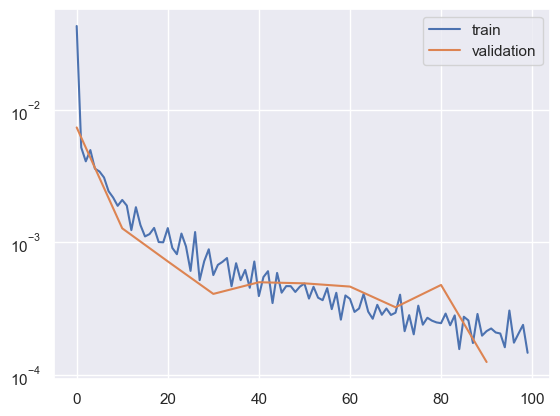

In [19]:
# Log Plot train and validation loss
plt.semilogy(np.arange(0, epochs, 1), epoch_train_losses, label='train')
plt.semilogy(np.arange(0, epochs, 10), epoch_validation_losses, label='validation')
plt.legend()
plt.show()

In [20]:
# Save model
save_model(model, 'cnn_test')

In [21]:
# save results
save_results(epoch_train_losses, 'cnn_test', 'train_losses')
save_results(epoch_validation_losses, 'cnn_test', 'validation_losses')

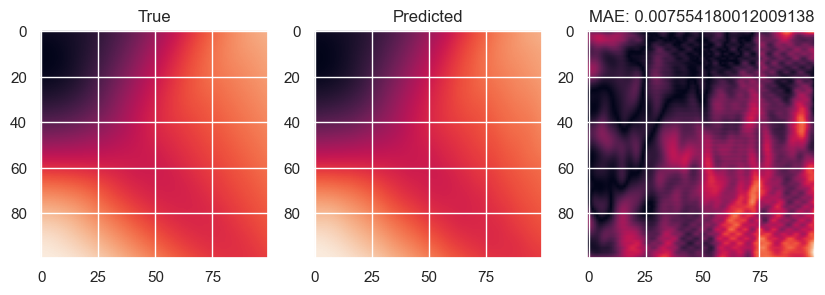

In [22]:
# Predict trajectories for 1000 intial conditions
def predict_trajectories(model, dataset):
    # Load the dataset
    xs = dataset['x'][0]
    ts = dataset['t'][0]
    ys = dataset['y'][0]
    us = dataset['u'][0]

    XT = np.meshgrid(xs, ts)
    trunk_input = torch.from_numpy(np.vstack([XT[0].ravel(), XT[1].ravel()]).T).float()
    branch_input = torch.from_numpy(us).float()

    model.eval()
    deep_output = np.zeros_like(ys)

    with torch.no_grad():    
        for i, xt in enumerate(trunk_input):
            j = i // 100
            deep_output[i % 100, j] = model(branch_input.unsqueeze(0), xt.unsqueeze(0)).item()

    return deep_output

dataset = np.load(root + '/data/training2/900.npy', allow_pickle=True)
true_y = dataset['y'][0]
trajectories = predict_trajectories(model, dataset)

error = np.abs(true_y - trajectories)
mae = np.mean(error)

# Plot trajectories
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(true_y)
ax[0].set_title('True')
ax[1].imshow(trajectories)
ax[1].set_title('Predicted')
ax[2].imshow(error)
ax[2].set_title('MAE: {}'.format(mae))
plt.show()
